# CMSC 636, HW3: Multilayer perceptron on MNIST dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from types import SimpleNamespace
%matplotlib inline

## Load MNIST

In [2]:
# load mnist dataset with labels encoded as one-hot vectors
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)
    
    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)
            
def load_mnist():
    def preprocess(data, labels, num_classes):
        # flatten images
        data = data.astype(np.float32)/255.0
        data = np.reshape(data, [data.shape[0], -1])
        # one hot encoding
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot
    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(
        train=Dataset(train), 
        test=Dataset(test))
mnist = load_mnist()

## Model definition

In [3]:
sess = tf.InteractiveSession()

In [4]:
input_size= 28*28
n_outputs=  10
n_hidden = 100
batch_size= 100

Define the computation graph. i.e:

h1 = relu(x w1 + b1) </br> logits = h1 w2 + b2 </br>

Where "x w1" is a matrix multiplication between the matices x and w1. The matrix x is a matrix whose rows represent the training input data.

In [9]:
# Define MLP
w1 = tf.Variable(
    tf.truncated_normal(
        shape=[input_size, n_hidden],
        stddev=0.1), 
    name= 'w1')
b1 = tf.Variable(
    tf.truncated_normal(
        shape=[n_hidden], 
        stddev=0.1), 
    name= 'b2') # TODO

w2 = tf.Variable(
    tf.truncated_normal(
        shape=[n_hidden, n_outputs],
        stddev=0.1), 
    name= 'w2') # TODO
b2 = tf.Variable(
    tf.truncated_normal(
        shape=[n_outputs], 
        stddev=0.1), 
    name= 'b2')

w3 = tf.Variable(
    tf.truncated_normal(
        shape=[n_hidden, n_outputs],
        stddev=0.1), 
    name= 'w3') # TODO
b3 = tf.Variable(
    tf.truncated_normal(
        shape=[n_outputs], 
        stddev=0.1), 
    name= 'b3')

# Define train setup
inputs = tf.placeholder(tf.float32, [None, input_size])
labels = tf.placeholder(tf.float32, [None, n_outputs])


h1 = tf.nn.relu(tf.matmul(inputs, w1) + b1)
h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
logits = tf.matmul(h1, w3) + b3

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, 
    labels=labels)) 

# Optimizer.
optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss) 
  
# Predictions for the training, validation, and test data.
yp = tf.nn.softmax(logits)

## Training

In [10]:
def accuracy(predictions, labels):
    if n_outputs == 1:
        return (100.0 * np.sum(np.greater(predictions, 0.5) == np.greater(labels, 0.5))/ predictions.shape[0])
    else:
        return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

In [15]:
num_steps = 10000
summary_freq= 200
n_test_logg= 10 # number of evaluations on test dataset (for logging information)

tf.global_variables_initializer().run()
print('Initialized')

# lists for plotting
l_epoch = []
l_train_accuracy = []
l_test_accuracy = []

mean_loss= 0
train_accuracy= 0
# Perform num_steps training steps
for step in range(num_steps):
    # Get next batch of 100 images
    batch_X, batch_y= mnist.train.next_batch(batch_size)    
    # Construct Feed dictionary that consist of the input data 
    # that is going to be feed into the computation graph
    feed_dict = {inputs : batch_X, labels : batch_y}
    # Call the optimizer to perform one step of the training
    _, l, train_pred = sess.run([optimizer, loss, yp],feed_dict=feed_dict)
    
    train_accuracy += accuracy(train_pred, batch_y)
    mean_loss += l    
    if step%summary_freq == 0:
        # Obtain train accuracy
        train_accuracy= train_accuracy/summary_freq
        # Evaluate accuracy on test dataset
        test_accuracy= 0
        for i in range(n_test_logg):
            batch_X_test, batch_y_test= mnist.test.next_batch(batch_size) 
            pred = yp.eval(feed_dict={inputs: batch_X_test})
            test_accuracy += accuracy(pred, batch_y_test)
        test_accuracy= test_accuracy/n_test_logg
        
        l_epoch.append(step)
        l_train_accuracy.append(train_accuracy)
        l_test_accuracy.append(test_accuracy)
            
        print(step, ', train:',train_accuracy,' | test:', test_accuracy, ' | loss:', mean_loss/summary_freq)
        mean_loss= 0
        train_accuracy= 0

Initialized
0 , train: 0.055  | test: 17.3  | loss: 0.012469938993453979
200 , train: 82.87  | test: 90.0  | loss: 0.6320286952704192
400 , train: 91.6  | test: 93.9  | loss: 0.29736926265060903
600 , train: 93.49  | test: 93.8  | loss: 0.23146034937351942
800 , train: 94.215  | test: 94.0  | loss: 0.20456386815756558
1000 , train: 94.85  | test: 95.1  | loss: 0.18134552240371704
1200 , train: 95.58  | test: 96.9  | loss: 0.15456819029524924
1400 , train: 95.635  | test: 96.2  | loss: 0.14621658761054276
1600 , train: 96.145  | test: 95.0  | loss: 0.13357328878715635
1800 , train: 96.585  | test: 96.3  | loss: 0.11669670758768916
2000 , train: 96.66  | test: 97.8  | loss: 0.11570818544365466
2200 , train: 97.185  | test: 97.0  | loss: 0.10228594450280071
2400 , train: 97.36  | test: 96.5  | loss: 0.09036898610182106
2600 , train: 97.385  | test: 97.0  | loss: 0.09126939804293216
2800 , train: 97.42  | test: 97.5  | loss: 0.0900738795567304
3000 , train: 97.855  | test: 97.0  | loss: 0.

## Test the model using testing dataset

Actual number: 3
Prediction by the model: 3


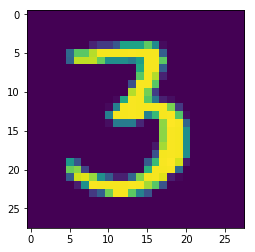

In [16]:
# Acquire one sample from the mnist dataset
test_sample_x, test_sample_y= mnist.test.next_batch(1) 

# Get a prediction for this sample
pred = yp.eval(feed_dict={inputs: test_sample_x})

print('Actual number:', np.argmax(test_sample_y))
print('Prediction by the model:', np.argmax(pred))

# plot
plt.imshow(np.reshape(test_sample_x, [28,28]))

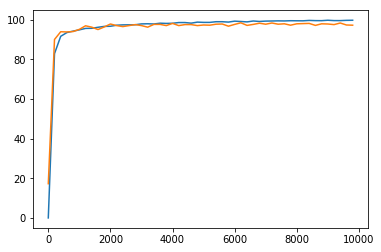

In [17]:
plt.plot(l_epoch, l_train_accuracy, label="Training Accuracy")
plt.plot(l_epoch, l_test_accuracy, label="Testing Accuracy")